In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import warnings 
warnings.filterwarnings("ignore")

## Brewer's Friend Beer Recipes

This is a dataset of 75,000 homebrewed beers with over 176 different styles. Beer records are user-reported and are classified according to one of the 176 different styles. These recipes go into as much or as little detail as the user provided, but there's are least 5 useful columns where data was entered for each: Original Gravity, Final Gravity, ABV, IBU, and Color

Font: https://www.kaggle.com/datasets/jtrofe/beer-recipes

In [63]:
df = pd.read_csv('recipeData.csv', encoding= "ISO-8859-1")

# Contar as ocorrências de cada StyleID
contagem_classe = df['StyleID'].value_counts()

# Filtrar o DataFrame para manter apenas as linhas com mais de 1000 amostras
df_filtrado = df[df['StyleID'].isin(contagem_classe[contagem_classe > 1000].index)]

percen_faltantes = round((df_filtrado.isnull().sum() / len(df_filtrado['Style']) )*100, 2)
percen_faltantes

BeerID            0.00
Name              0.01
URL               0.00
Style             0.00
StyleID           0.00
Size(L)           0.00
OG                0.00
FG                0.00
ABV               0.00
IBU               0.00
Color             0.00
BoilSize          0.00
BoilTime          0.00
BoilGravity       3.67
Efficiency        0.00
MashThickness    40.92
SugarScale        0.00
BrewMethod        0.00
PitchRate        55.19
PrimaryTemp      31.80
PrimingMethod    91.84
PrimingAmount    94.20
UserId           69.32
dtype: float64

In [64]:
# Váriaveis strings
sugar = pd.get_dummies(df_filtrado['SugarScale']).astype(int)
brew = pd.get_dummies(df_filtrado['BrewMethod']).astype(int)
concatenado = pd.concat([df_filtrado, sugar, brew], axis=1)

# Preenchendo dados faltantes pela mediana, performa melhor caso tenha outliers
concatenado['PrimaryTemp'].fillna(concatenado['PrimaryTemp'].median(), inplace= True ) 
concatenado['BoilGravity'].fillna(concatenado['BoilGravity'].median(), inplace= True ) 

# Excluindo variaveis com dados faltantes acima de 40%
concatenado.drop(['BeerID', 'Name', 'URL', 'Style', 'PrimingAmount', 'PrimingMethod', 'UserId', 'PitchRate',
         'MashThickness', 'PitchRate', 'SugarScale', 'BrewMethod']
        , axis=1, inplace=True)

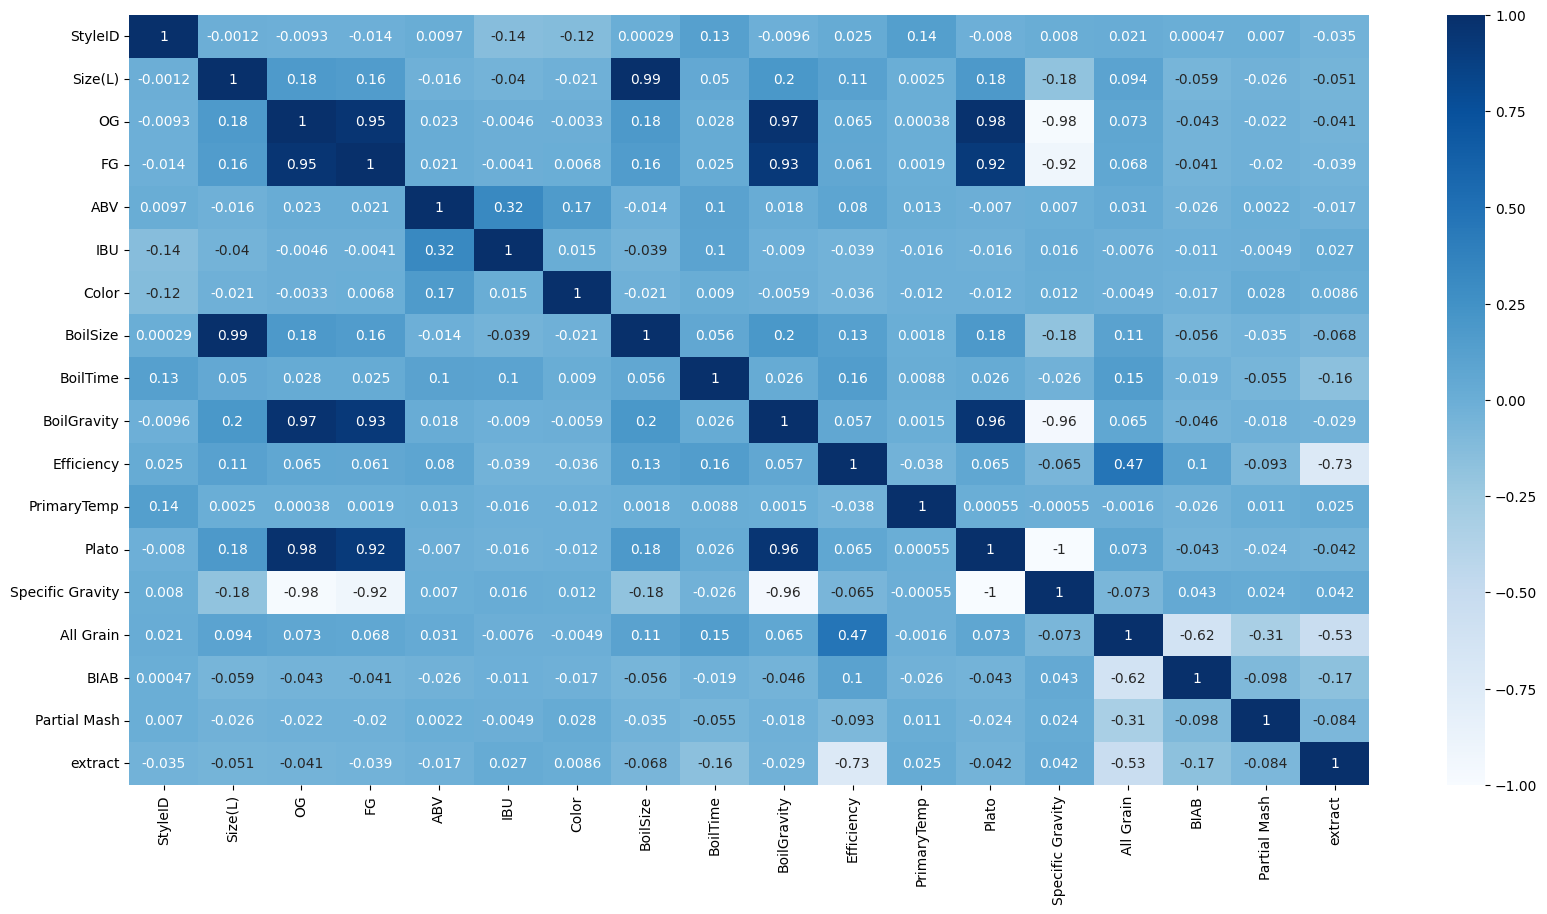

In [65]:
plt.figure(figsize = (20,10))
sns.heatmap(concatenado.corr(method = 'pearson', numeric_only=True ), annot= True, 
            cmap = sns.color_palette("Blues", as_cmap=True))
plt.show()

# Excluindo correlações muito elevadas, acima de 70%
concatenado.drop(['Plato', 'BoilGravity', 'OG', 'Size(L)', 'FG', 'Efficiency']
        , axis=1, inplace=True)

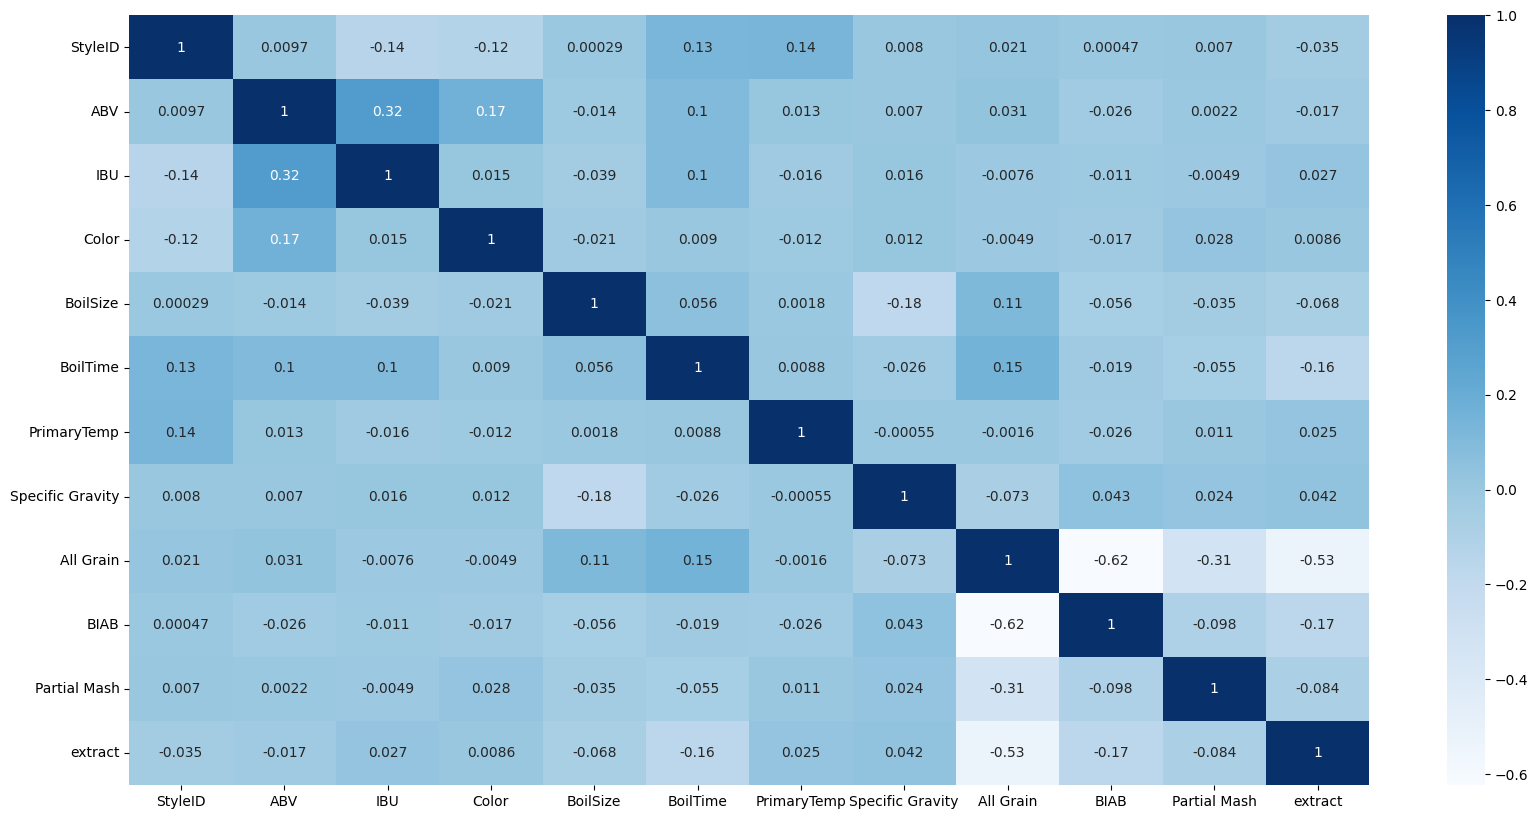

In [66]:
plt.figure(figsize = (20,10))
sns.heatmap(concatenado.corr(method = 'pearson', numeric_only=True ), annot= True, 
            cmap = sns.color_palette("Blues", as_cmap=True))
plt.show()

x_beer = concatenado.loc[:, concatenado.columns != 'StyleID']
y_beer = concatenado.loc[:, concatenado.columns == 'StyleID']
y_beer['StyleID'] = y_beer['StyleID'].astype('category')

## Regressão Logistica

In [67]:
# Separando folds
str_kfold = StratifiedKFold(n_splits=5)

# Valores a serem testados
Val_C_can = np.array([95, 100, 105, 110, 120])
regul_can = ['l1' , 'l2']
val_grid_can = {'C': Val_C_can, 'penalty': regul_can} # C é o lambda da regularização

# Modelo
modelo_log_beer = LogisticRegression(solver='liblinear')

#Criando Grids
procura_beer = GridSearchCV(estimator= modelo_log_beer, param_grid= val_grid_can,  cv = str_kfold, n_jobs=-1) # Essa função testa todas as combinações possíveis
procura_beer.fit(x_beer, y_beer)

#Imprimindo a melhor acurácia
print("Melhor Acurácia:", procura_beer.best_score_)
print("Parâmetro C:", procura_beer.best_estimator_.C)
print("Regularização:", procura_beer.best_estimator_.penalty)

Melhor Acurácia: 0.4432587556041884
Parâmetro C: 120
Regularização: l1


## Árvore de Decisão

In [68]:
# parametros
parametros_grid = {
    'criterion': ['gini','entropy'],
    'max_depth': [5,6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8]
    ##'min_samples_leaf': [1, 2, 3]
}

modelo = DecisionTreeClassifier()

gridDecisionTree = GridSearchCV(estimator= modelo, param_grid= parametros_grid, cv = str_kfold, scoring=  'f1_micro', n_jobs= -1)
gridDecisionTree.fit(x_beer, y_beer)

#Imprimindo melhores parâmetros
print("Mínimo Split:", gridDecisionTree.best_estimator_.min_samples_split)
print("Máxima Profundidade:",gridDecisionTree.best_estimator_.get_params()['max_depth'])
print("Algoritmo Escolhido:",gridDecisionTree.best_estimator_.criterion)
print("Acurácia:",gridDecisionTree.best_score_)


Mínimo Split: 7
Máxima Profundidade: 8
Algoritmo Escolhido: entropy
Acurácia: 0.5899105043341182


## KNN

In [69]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import numpy as np  

# Normalizando as váriaveis preditoras, pois estamos trabalhando com distâncias de váriaveis diferentes
normalizador = MinMaxScaler(feature_range=(0,1))
X_norm = normalizador.fit_transform(x_beer)

valores_K = np.array([13,14,15])
distancia = ['minkowski','chebyshev']
valores_p = np.array([1, 2,3, 4]) # p = 2 é equivalente a distancia euclidiana e p = 1 é equivalente a Manhattan, usando a formula da minkowski
valores_grid = {'n_neighbors': valores_K, 'metric': distancia, 'p':valores_p}

# Modelo
modelo_knn = KNeighborsClassifier()

#Criando Grids
GriddKNN = GridSearchCV(estimator=modelo_knn, param_grid= valores_grid, cv = 5, n_jobs=-1)
GriddKNN.fit(X_norm,y_beer)

# Imprimindo melhores parâmetros
print('Melhor Acurácia:', GriddKNN.best_score_)
print('Melhor K:', GriddKNN.best_estimator_.n_neighbors)
print('Método Distância:', GriddKNN.best_estimator_.metric)
print('Melhor Valor de p:', GriddKNN.best_estimator_.p)

Melhor Acurácia: 0.5701500254830929
Melhor K: 15
Método Distância: minkowski
Melhor Valor de p: 1


## Feature Selection

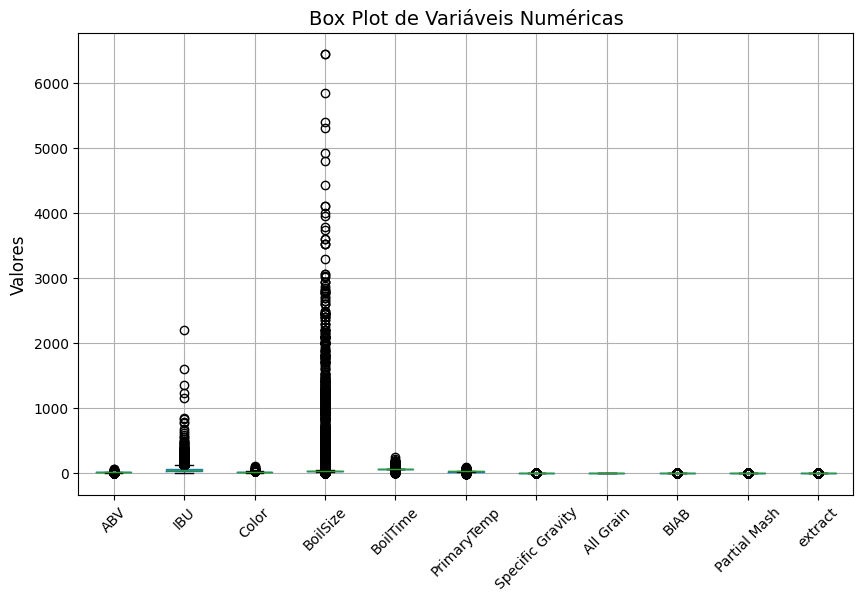

In [70]:
import matplotlib.pyplot as plt

# Selecione apenas as colunas numéricas para o box plot
df_numeric = x_beer.select_dtypes(include='number')

# Configure o tamanho da figura
plt.figure(figsize=(10, 6))

# Crie o box plot para cada variável numérica
df_numeric.boxplot(rot=45, fontsize=10)

# Adicione um título ao gráfico
plt.title('Box Plot de Variáveis Numéricas', fontsize=14)

# Rotule o eixo Y
plt.ylabel('Valores', fontsize=12)

# Exiba o box plot
plt.show()

In [71]:
# Calcule a média e o desvio padrão para cada coluna
mean_values = df_numeric.mean()
std_values = df_numeric.std()

# Calcule o limite superior para cada coluna (média + 2 * desvio padrão)
upper_limit = mean_values + 2 * std_values

# Calcule a porcentagem de casos em que o valor é maior que o limite superior para cada coluna
percentage_above_threshold = (df_numeric > upper_limit).mean() * 100

# Exiba a porcentagem para cada coluna
print("Porcentagem de casos acima do limite para cada coluna:")
print(percentage_above_threshold)

Porcentagem de casos acima do limite para cada coluna:
ABV                  2.481369
IBU                  2.975384
Color                6.063686
BoilSize             1.769986
BoilTime            12.189476
PrimaryTemp          1.174345
Specific Gravity     0.000000
All Grain            0.000000
BIAB                16.313799
Partial Mash         4.725610
extract             12.356030
dtype: float64


In [72]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

# Escolhendo as duas varáveis mais importantes considerando maoir f-value
algoritmo_f = SelectKBest(score_func= f_classif, k=5) 

dados_melhores_pred_f = algoritmo_f.fit(x_beer,y_beer)

print('Scores:', algoritmo_f.scores_)
print('Colunas: \n', x_beer.columns[algoritmo_f.get_support(indices=True)])

x_beer_new = x_beer[x_beer.columns[algoritmo_f.get_support(indices=True)]]

Scores: [8.78164747e+02 1.09802589e+03 4.40330728e+03 7.82073299e+00
 9.63362140e+01 1.15172650e+02 1.29565432e+00 3.26833278e+00
 8.47794853e+00 2.36197425e+00 1.00392109e+01]
Colunas: 
 Index(['ABV', 'IBU', 'Color', 'BoilTime', 'PrimaryTemp'], dtype='object')


In [73]:
# Separando folds
str_kfold = StratifiedKFold(n_splits=5)

# Valores a serem testados
Val_C_can = np.array([95, 100, 105, 110, 120])
regul_can = ['l1' , 'l2']
val_grid_can = {'C': Val_C_can, 'penalty': regul_can} # C é o lambda da regularização

# Modelo
modelo_log_beer = LogisticRegression(solver='liblinear')

#Criando Grids
procura_beer = GridSearchCV(estimator= modelo_log_beer, param_grid= val_grid_can,  cv = str_kfold, n_jobs=-1) # Essa função testa todas as combinações possíveis
procura_beer.fit(x_beer_new, y_beer)

#Imprimindo a melhor acurácia
print("Regressão Logistica")
print("Melhor Acurácia:", procura_beer.best_score_)
print("Parâmetro C:", procura_beer.best_estimator_.C)
print("Regularização:", procura_beer.best_estimator_.penalty)

Regressão Logistica
Melhor Acurácia: 0.4408027991155235
Parâmetro C: 95
Regularização: l2


In [77]:
# parametros
parametros_grid = {
    'criterion': ['gini','entropy'],
    'max_depth': [5,6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8]
    ##'min_samples_leaf': [1, 2, 3]
}

modelo = DecisionTreeClassifier()

gridDecisionTree = GridSearchCV(estimator= modelo, param_grid= parametros_grid, cv = str_kfold, scoring=  'f1-micro', n_jobs= -1)
gridDecisionTree.fit(x_beer_new, y_beer)

#Imprimindo melhores parâmetros
print("Avore de Decisão")
print("Mínimo Split:", gridDecisionTree.best_estimator_.min_samples_split)
print("Máxima Profundidade:",gridDecisionTree.best_estimator_.get_params()['max_depth'])
print("Algoritmo Escolhido:",gridDecisionTree.best_estimator_.criterion)
print("Acurácia:",gridDecisionTree.best_score_)

InvalidParameterError: The 'scoring' parameter of GridSearchCV must be a str among {'accuracy', 'rand_score', 'jaccard_weighted', 'neg_log_loss', 'roc_auc_ovo_weighted', 'neg_mean_squared_log_error', 'neg_mean_gamma_deviance', 'precision_samples', 'jaccard_macro', 'average_precision', 'neg_mean_absolute_percentage_error', 'mutual_info_score', 'completeness_score', 'roc_auc', 'r2', 'neg_root_mean_squared_log_error', 'recall_macro', 'roc_auc_ovr', 'homogeneity_score', 'max_error', 'adjusted_mutual_info_score', 'f1_macro', 'f1', 'neg_brier_score', 'jaccard_micro', 'fowlkes_mallows_score', 'neg_root_mean_squared_error', 'top_k_accuracy', 'neg_mean_squared_error', 'recall_samples', 'f1_micro', 'matthews_corrcoef', 'jaccard_samples', 'roc_auc_ovo', 'f1_samples', 'adjusted_rand_score', 'balanced_accuracy', 'neg_mean_absolute_error', 'precision_micro', 'neg_median_absolute_error', 'precision', 'jaccard', 'recall_micro', 'explained_variance', 'neg_negative_likelihood_ratio', 'roc_auc_ovr_weighted', 'v_measure_score', 'precision_macro', 'recall_weighted', 'neg_mean_poisson_deviance', 'precision_weighted', 'positive_likelihood_ratio', 'normalized_mutual_info_score', 'recall', 'f1_weighted'}, a callable, an instance of 'list', an instance of 'tuple', an instance of 'dict' or None. Got 'f1-micro' instead.

In [75]:
# Normalizando as váriaveis preditoras, pois estamos trabalhando com distâncias de váriaveis diferentes
normalizador = MinMaxScaler(feature_range=(0,1))
X_norm = normalizador.fit_transform(x_beer_new)

valores_K = np.array([10,11,12,13,14,15])
distancia = ['minkowski','chebyshev']
valores_p = np.array([1, 2,3, 4]) # p = 2 é equivalente a distancia euclidiana e p = 1 é equivalente a Manhattan, usando a formula da minkowski
valores_grid = {'n_neighbors': valores_K, 'metric': distancia, 'p':valores_p}

# Modelo
modelo_knn = KNeighborsClassifier()

#Criando Grids
GriddKNN = GridSearchCV(estimator=modelo_knn, param_grid= valores_grid, cv = 5 )
GriddKNN.fit(X_norm,y_beer)

# Imprimindo melhores parâmetros
print('KNN')
print('Melhor Acurácia:', GriddKNN.best_score_)
print('Melhor K:', GriddKNN.best_estimator_.n_neighbors)
print('Método Distância:', GriddKNN.best_estimator_.metric)
print('Melhor Valor de p:', GriddKNN.best_estimator_.p)

KNN
Melhor Acurácia: 0.5814416935278522
Melhor K: 15
Método Distância: minkowski
Melhor Valor de p: 1
